<a href="https://colab.research.google.com/github/erencsknn/spark_project/blob/main/spark_project_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and loading necessary libraries

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3333df505ea68d0ee4996ade408b5bc12c4f49a421c7511139ce946e8c1be843
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark import SparkContext

In [ ]:

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import numpy as np
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import pandas as pd


## A SparkSession object was created for Apache Spark.

In [ ]:
spark = SparkSession.builder.getOrCreate()

# The dataset was uploaded using the Kaggle API.

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # kaggle.json dosyanızı yükleyin

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erencoskunn","key":"0eca10a1cd1754de5523255e8f1b4f91"}'}

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d camnugent/california-housing-prices

100% 400k/400k [00:00<00:00, 1.05MB/s]
100% 400k/400k [00:00<00:00, 1.05MB/s]


In [ ]:
!unzip california-housing-prices.zip

Archive:  california-housing-prices.zip
  inflating: housing.csv             


## The housing.csv CSV file was read through Spark.

In [ ]:
data = spark.read.csv("housing.csv",inferSchema=True, header=True)
data.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

##The schema of the DataFrame was printed. The schema of a DataFrame defines its structure, specifying the names of the columns it contains along with their data types.

In [ ]:
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



## Basic statistical information about the dataset was displayed quickly

In [ ]:
data.select(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

## The number of missing values was calculated for each column, and this information was printed on the screen.

In [ ]:
for column in data.columns:
    print(column, data.filter(col(column).cast("float").isin([None,np.nan])).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [ ]:
# data.na.drop()

##These lines are intended for exploring and analyzing the distribution and statistical properties of the 'median_house_value' column by visualizing it.

+----------------------------+----------------------------+
|skewness(median_house_value)|kurtosis(median_house_value)|
+----------------------------+----------------------------+
|          0.9776922140978437|          0.3275001388119674|
+----------------------------+----------------------------+



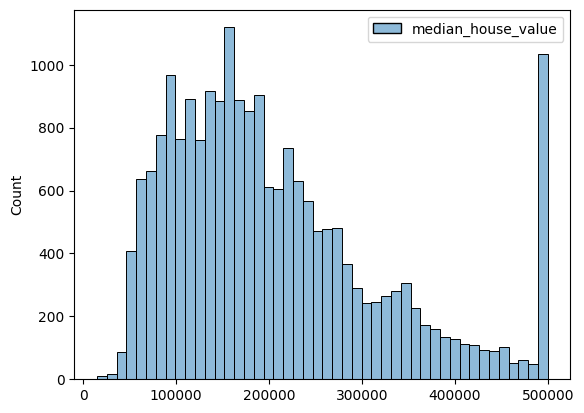

In [ ]:
# Dağılım grafiğini oluştur
sns.histplot(data.select('median_house_value').toPandas(), color="skyblue")

# Skewness ve kurtosis hesaplamalarını yap ve göster
data.select(F.skewness('median_house_value'), F.kurtosis('median_house_value')).show()

## A histogram of the 'median_house_value' column was created using the Seaborn library.

<Axes: ylabel='Count'>

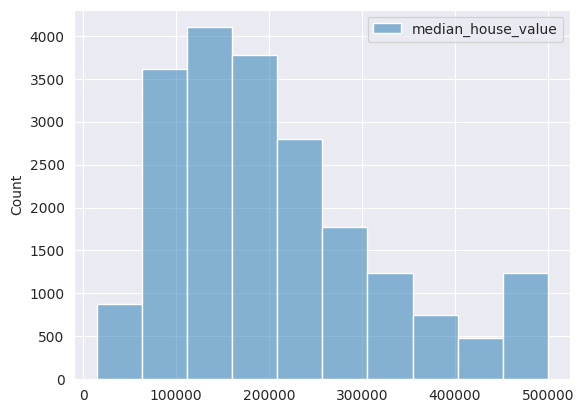

In [ ]:
sns.set_style("darkgrid")
sns.histplot(data.select('median_house_value').toPandas(), bins = 10)

## This code aimed to calculate the average house prices based on the 'total_rooms' column and visualize this information to examine the impact of the number of rooms on house prices.

<Axes: xlabel='total_rooms', ylabel='avg(median_house_value)'>

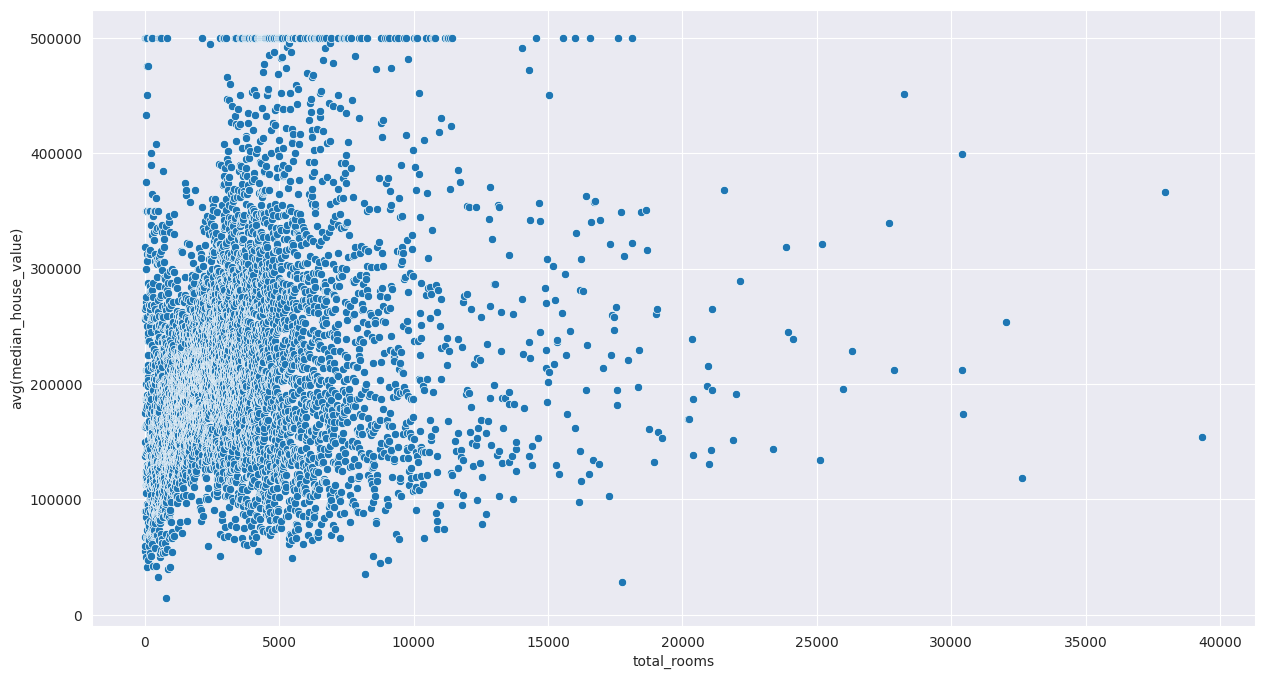

In [ ]:
#Average price of house
import matplotlib.pyplot as plt
df1 = data.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(median_house_value)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(median_house_value)'] )

 ## A new 'per_capita_income' column is added to the DataFrame, representing the per capita income of each household as a value per person.

In [ ]:
df_housing = data.withColumn('per_capita_income', data['median_income']*10000/data['population'])

## Seaborn library was used to visualize the distribution of the 'per_capita_income' column.

[(0.0, 500.0)]

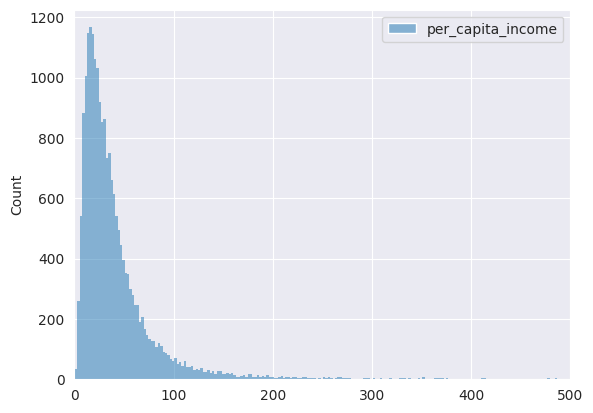

In [ ]:
g = sns.histplot(df_housing.select('per_capita_income').toPandas())
g.set(xlim=(0, 500))

## The following cell was used to visualize the relationship between 'per_capita_income' (per capita income) and 'median_house_value' (house prices).

<Axes: xlabel='per_capita_income', ylabel='median_house_value'>

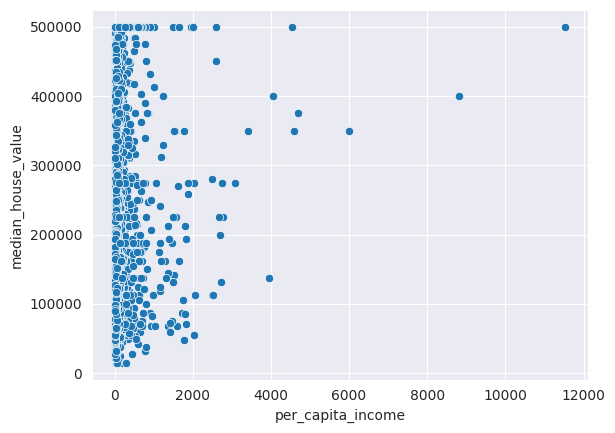

In [ ]:
#Per-capita-income and prices of the home
df_p = df_housing.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['median_house_value'])

#A lot of data has near $100 per-capita income - data is skewed towards zero.

## The following code snippets are used to calculate the percentage of blocks in the dataset with per capita income less than $100 and print this information on the screen.

In [ ]:
# Counting per capita that are less than $100
count_blocks = df_housing.filter('per_capita_income <  100').count()/df_housing.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 92.596899


## The following code selects unique values in the 'ocean_proximity' column and prints them to the screen.

In [ ]:
unique_values = data.select("ocean_proximity").distinct()
unique_values.show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



##The following code snippets calculate the average incomes of houses according to different categories of ocean proximity and visualize this information with a bar graph.

<Axes: xlabel='ocean_proximity', ylabel='avg(median_income)'>

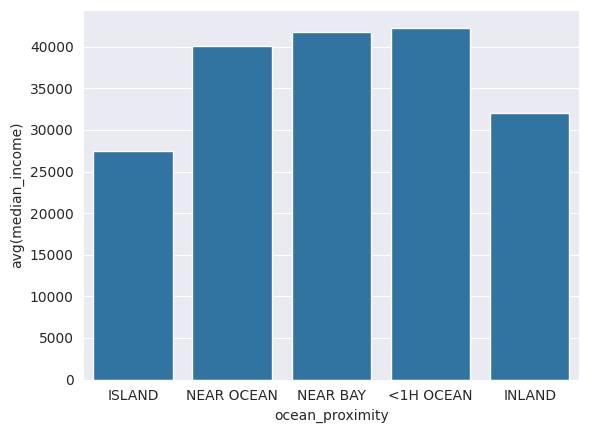

In [ ]:
df_i = df_housing.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)

##The following code snippets calculate the median value of houses according to different categories of ocean proximity and visualize this information with a bar graph.

<Axes: xlabel='ocean_proximity', ylabel='avg(median_house_value)'>

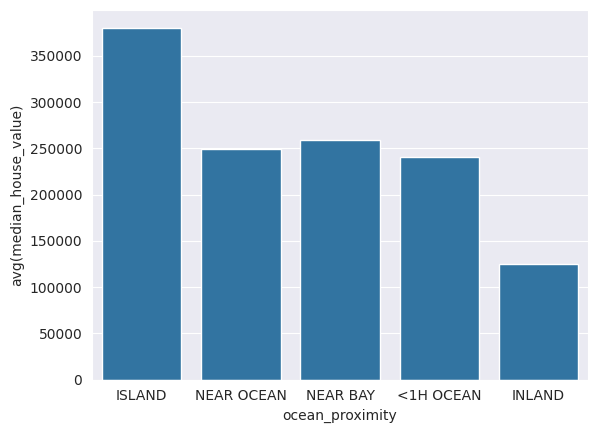

In [ ]:
df_i = df_housing.groupby('ocean_proximity').agg({'median_house_value' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_house_value)'])

## The following code snippets use StringIndexer to convert categorical values in the 'ocean_proximity' column into numerical values and then remove the original 'ocean_proximity' column after this operation.

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
df_housing = indexer.fit(df_housing).transform(df_housing)
df_housing = df_housing.drop('ocean_proximity')
df_housing.select('ocean_proximity_index').show()

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 20 rows



## The following code displays the unique values after StringIndexer.

In [ ]:
unique_values_2 = df_housing.select("ocean_proximity_index").distinct()
unique_values_2.show()

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  0.0|
|                  1.0|
|                  4.0|
|                  3.0|
|                  2.0|
+---------------------+



In [ ]:
mean = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
df_housing = df_housing.na.fill({'total_bedrooms': mean})

In [ ]:
df_housing.filter(col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------+---------------------+



## Feature columns have been identified.


# The following code snippets use the Correlation class that comes with PySpark to calculate the correlation matrix between columns in the DataFrame, visualize it with a heatmap, and remove values higher than a specific threshold.

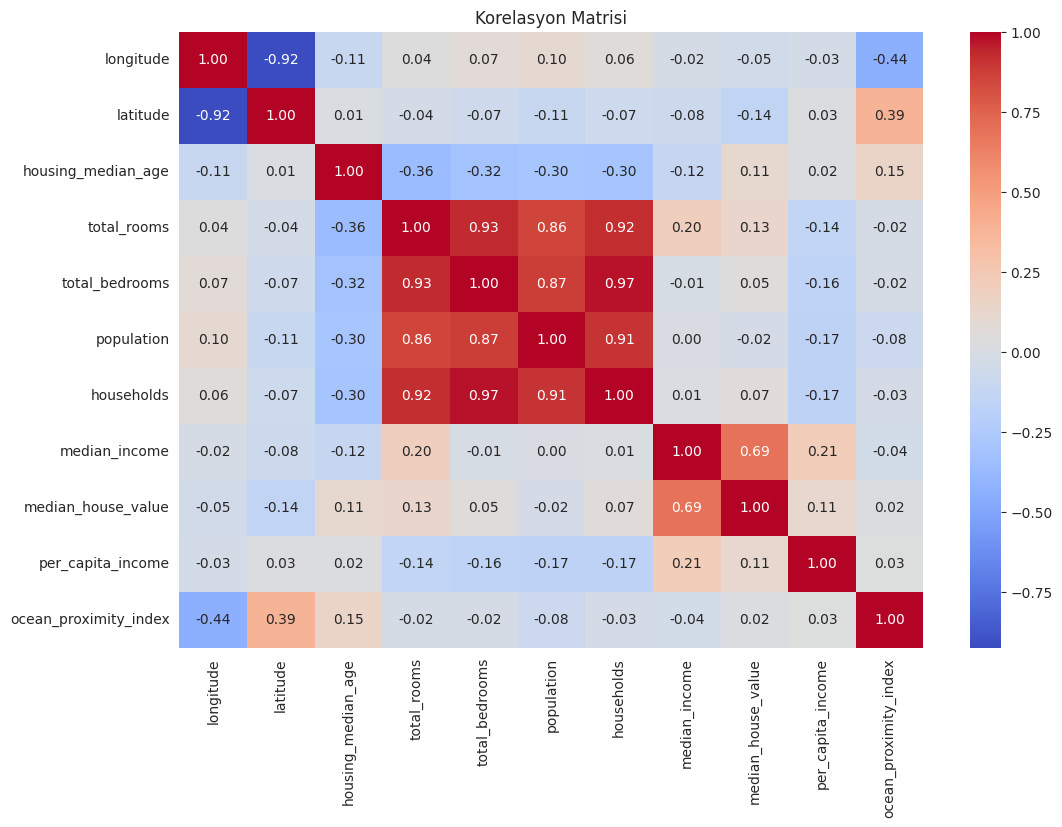

+------------------+-------------+------------------+------------------+---------------------+
|housing_median_age|median_income|median_house_value| per_capita_income|ocean_proximity_index|
+------------------+-------------+------------------+------------------+---------------------+
|              41.0|       8.3252|          452600.0|258.54658385093165|                  3.0|
|              21.0|       8.3014|          358500.0| 34.57476051645147|                  3.0|
|              52.0|       7.2574|          352100.0|146.31854838709677|                  3.0|
|              52.0|       5.6431|          341300.0|101.13082437275985|                  3.0|
|              52.0|       3.8462|          342200.0| 68.07433628318584|                  3.0|
+------------------+-------------+------------------+------------------+---------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.stat import Correlation
assembler = VectorAssembler(inputCols=df_housing.columns,outputCol="features")

df_vector = assembler.transform(df_housing).select("features")

matrix = Correlation.corr(df_vector,'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

df_corr = pd.DataFrame(corrmatrix, columns = df_housing.columns, index = df_housing.columns)

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Korelasyon Matrisi")
plt.show()


threshold = 0.9
high_correlations = df_corr[abs(df_corr) > threshold].stack().reset_index()
high_correlations.columns = ['Column1', 'Column2', 'Correlation']

# Bir sütun çifti sadece bir kez gösterilir
high_correlations = high_correlations[high_correlations['Column1'] < high_correlations['Column2']]

# Seçilen sütunları göster
selected_columns = set(high_correlations['Column1']).union(set(high_correlations['Column2']))

# Seçilen sütunları orijinal DataFrame'den çıkar
df_model = df_housing.drop(*list(selected_columns))
df_model.show(5)


## The following code lines are used to evaluate how well the 'housing_median_age' feature fits into a normal distribution. While the histogram and density plot visually indicate how closely it resembles a normal distribution, skewness and kurtosis statistics evaluate the distribution's normality numerically.


<ipython-input-30-1cbf3f7740ed>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model.select('housing_median_age').toPandas(), color="skyblue")


+----------------------------+----------------------------+
|skewness(housing_median_age)|kurtosis(housing_median_age)|
+----------------------------+----------------------------+
|        0.060326253016608676|         -0.8007255995445028|
+----------------------------+----------------------------+



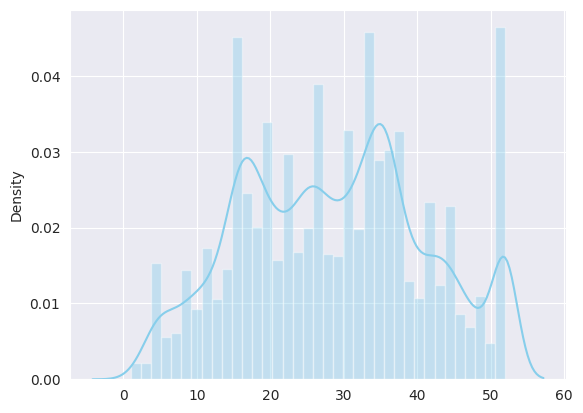

In [ ]:
#Checking normal distribution of selected fetures
#housing_median_age

sns.distplot(df_model.select('housing_median_age').toPandas(), color="skyblue")
df_housing.select(F.skewness('housing_median_age'), F.kurtosis('housing_median_age')).show()

## The following code lines are used to evaluate how well the 'median_income' feature fits into a normal distribution. While the histogram and density plot visually indicate how closely it resembles a normal distribution, skewness and kurtosis statistics evaluate the distribution's normality numerically.


<ipython-input-31-56c5a1191dcb>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model.select('median_income').toPandas(), color="skyblue")


+-----------------------+-----------------------+
|skewness(median_income)|kurtosis(median_income)|
+-----------------------+-----------------------+
|     1.6465370299001063|      4.951033760409806|
+-----------------------+-----------------------+



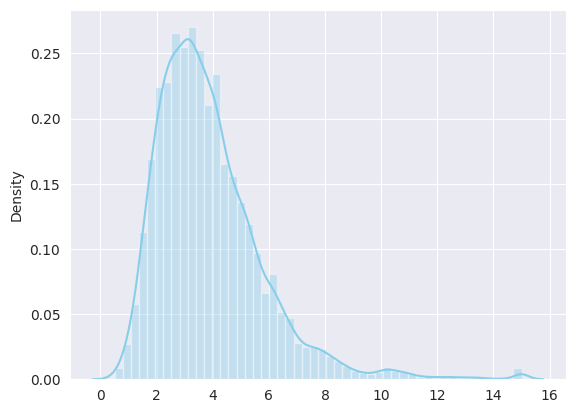

In [ ]:
#Checking normal distribution of selected fetures
#median_income

sns.distplot(df_model.select('median_income').toPandas(), color="skyblue")
df_housing.select(F.skewness('median_income'), F.kurtosis('median_income')).show()

#the median_income is normally distributed

##  The following code lines concatenate all numerical columns in the DataFrame into a feature vector, excluding the target column.

In [ ]:
#Assembling features
selected_columns = [col for col in df_model.columns if col != 'median_house_value']
feature_assembly = VectorAssembler(inputCols = selected_columns, outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+------------------+-------------+------------------+------------------+---------------------+--------------------+
|housing_median_age|median_income|median_house_value| per_capita_income|ocean_proximity_index|            features|
+------------------+-------------+------------------+------------------+---------------------+--------------------+
|              41.0|       8.3252|          452600.0|258.54658385093165|                  3.0|[41.0,8.3252,258....|
|              21.0|       8.3014|          358500.0| 34.57476051645147|                  3.0|[21.0,8.3014,34.5...|
|              52.0|       7.2574|          352100.0|146.31854838709677|                  3.0|[52.0,7.2574,146....|
+------------------+-------------+------------------+------------------+---------------------+--------------------+
only showing top 3 rows



## The following code lines use StandardScaler to normalize the feature vectors.

In [ ]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler,MinMaxScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+------------------+-------------+------------------+------------------+---------------------+--------------------+--------------------+
|housing_median_age|median_income|median_house_value| per_capita_income|ocean_proximity_index|            features|      scaledFeatures|
+------------------+-------------+------------------+------------------+---------------------+--------------------+--------------------+
|              41.0|       8.3252|          452600.0|258.54658385093165|                  3.0|[41.0,8.3252,258....|[3.25770230160830...|
|              21.0|       8.3014|          358500.0| 34.57476051645147|                  3.0|[21.0,8.3014,34.5...|[1.66857922765303...|
|              52.0|       7.2574|          352100.0|146.31854838709677|                  3.0|[52.0,7.2574,146....|[4.13171999228370...|
+------------------+-------------+------------------+------------------+---------------------+--------------------+--------------------+
only showing top 3 rows



##The following code lines create a DataFrame, df_model_final, containing normalized feature vectors and the target variable ('median_house_value') column.

In [ ]:
#Selecting input and output column from output
df_model_final = scaledOutput.select(['median_house_value', 'scaledFeatures'])
df_model_final.show(3)

+------------------+--------------------+
|median_house_value|      scaledFeatures|
+------------------+--------------------+
|          452600.0|[3.25770230160830...|
|          358500.0|[1.66857922765303...|
|          352100.0|[4.13171999228370...|
+------------------+--------------------+
only showing top 3 rows



## The following code lines split the dataset into training and test subsets and then create a decision tree regression model.

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

#test train split
# train, test = df_model_final.randomSplit([0.8, 0.2], seed=1)
regressor = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="median_house_value")



In [ ]:
# train.show()

# The following codes attempt to improve the performance of the machine learning model by training it with various combinations of hyperparameters and selecting the best combination from these,

## Lineer Regression :
### test verisi R2 değeri: 0.5180765477452081
### test verisi MSE değeri: 6568254740.840805
## RandomForestRegression
### test verisi R2 değeri: 0.6427510085439099
### test verisi MSE değeri: 4869035467.797633

## DecisionTreeRegressor
### test verisi R2 değeri: 0.6288313823162148
### test verisi MSE değeri: 5058749519.96302


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler
# paramGrid = ParamGridBuilder() \
#     .addGrid(regressor.regParam, [0.1, 0.01]) \
#     .addGrid(regressor.fitIntercept, [False, True])\
#     .addGrid(regressor.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .build()

# paramGrid = (ParamGridBuilder()
#              .addGrid(regressor.maxDepth, [3, 5, 7])
#              .addGrid(regressor.minInstancesPerNode, [1, 5, 10])
#              .build())

paramGrid = (ParamGridBuilder()
             .addGrid(regressor.maxDepth, [5, 10, 15])
             .addGrid(regressor.numTrees, [10, 20, 30])
             .build())
# paramGrid = (ParamGridBuilder()
#              .addGrid(regressor.maxDepth, [5, 10, 15])
#              .addGrid(regressor.maxIter, [10, 20, 30])
#              .build())


evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")



# Cross Validation
tvs  = TrainValidationSplit(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator().setLabelCol("median_house_value"),
                          )
evaluator = RegressionEvaluator(metricName="r2", labelCol="median_house_value", predictionCol="prediction")

model = tvs.fit(df_model_final)

model.transform(df_model_final)\
    .select("median_house_value", "scaledFeatures", "prediction")\
    .show()

+------------------+--------------------+------------------+
|median_house_value|      scaledFeatures|        prediction|
+------------------+--------------------+------------------+
|          452600.0|[3.25770230160830...| 479668.8973241765|
|          358500.0|[1.66857922765303...|430169.96404221695|
|          352100.0|[4.13171999228370...|  425915.468349446|
|          341300.0|[4.13171999228370...| 374641.4320404629|
|          342200.0|[4.13171999228370...|276251.87529597146|
|          269700.0|[4.13171999228370...|261180.97253758166|
|          299200.0|[4.13171999228370...| 335400.2131571625|
|          241400.0|[4.13171999228370...|287539.93019575946|
|          226700.0|[3.33715845530607...| 127387.2082832727|
|          261100.0|[4.13171999228370...|  342604.072229916|
|          281500.0|[4.13171999228370...| 307181.5205831163|
|          241800.0|[4.13171999228370...| 328694.0518040853|
|          213500.0|[4.13171999228370...|287539.93019575946|
|          191300.0|[4.1

## The following code lines calculate the R-squared and MSE regression evaluation metrics.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Model üzerinde tahmin yapmak
predictions = model.transform(df_model_final)

# R-kare değerini hesaplamak
evaluator = RegressionEvaluator(metricName="r2", labelCol="median_house_value", predictionCol="prediction")
r2 = evaluator.evaluate(predictions)
print("tüm veri R2 değeri:", r2)

# MSE değerini hesaplamak
evaluator = RegressionEvaluator(metricName="mse", labelCol="median_house_value", predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print("tüm veri MSE değeri:", mse)

tüm veri R2 değeri: 0.6981336381336781
tüm veri MSE değeri: 4019502447.277025
